## Dependency installation and data downloading and unpacking

In [ ]:
# Install dependencies
!python -m pip install spacy pandas numpy seaborn matplotlib scikit-learn dask pyarrow

# For lemmatization, make sure spaCy is installed along with its english module
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Download and extract the dataset for NLP with Disaster Tweets Kaggle competition
# !kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d nlp-getting-started

## Load / Reload project
This section just resets the dataframe to its original state

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load the datasets
og_train_df = pd.read_csv("nlp-getting-started/train.csv")
og_test_df = pd.read_csv("nlp-getting-started/test.csv")

In [3]:
og_train_df["id"].value_counts().sum()
og_test_df["id"].value_counts().sum()

np.int64(3263)

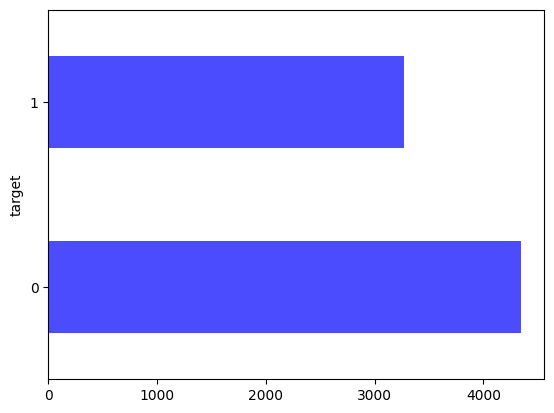

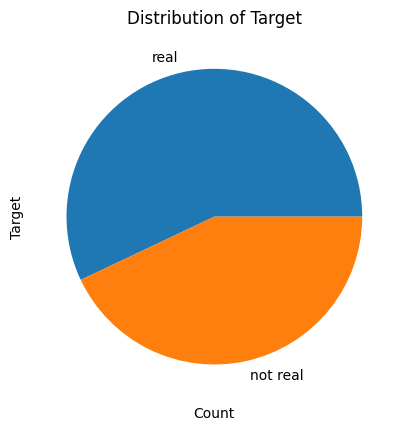

In [4]:
og_train_df["target"].value_counts().plot(kind='barh', color='blue', alpha=0.7)
plt.show()

plt.pie(og_train_df["target"].value_counts(), labels=["real", "not real"])
plt.xlabel("Count")
plt.ylabel("Target")
plt.title("Distribution of Target")
plt.show()

## Preprocessing
Preprocess the dataset before splitting it into the 70/30 distribution required by the assignment. Although we have followed the instruction's recommendations. We took some liberties with the order and depth to which we followed the instructions. Thus, our preprocesing consists of:

1. Removing punctuation  - This is helpful in standardizing the texts, but can create some isues in multiword lexical units and names. To solve this, a name entity recognition should be applied before this step.

2. Converting all text to lower case - As with the previous point, this help in standardization. Makes the text uniform and minimizes the influence of grammatical errors or stylized text.

3. Stopword removal - Stopwords are lexical units that have no semantic meaning; they are present to satisfy the syntactic requirements of the language. Thus, they are of little to no use to us in this assignment. The list of stopwords used in this program was provided on [this website](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt)

4. Lemmatization - This helps the system identify all lexemes of a lexical unit as a single lexical unit. Avoids redundant storage missuse and improves accuracy. For this step, due to implementational advantages brought by spaCy, spaCy was used instead of NLTK as the assignment description reccommended. 

5. Handling null values - This dataset contains some null values in some columns, thus we used the `pandas.fillna()` method to fill these spots. Text columns with an `No Value` string, and numeric columns with a Zero value.

6. Training dataset 70/30 split - Since our test dataset does not contain the target values we aim to predict, we must use a subset of our training set for the purposes of fine-tuning the model. Another option to consider would be running a k-fold structure.

In [5]:
# Remove punctuation to allow for better word manipulation, except in hyphenation cases, an exception we're willing to make given that this is not a deep linguistic analisys. However, if we wanted to maintain the most semantic context, a name entity recognition system should parse this text beforehand.
import string

print(og_train_df['text'].head())

# Remove punctuation using translate
og_train_df["text"] = og_train_df["text"].str.translate(str.maketrans("", "", string.punctuation))
print(og_train_df['text'].head())

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0    Our Deeds are the Reason of this earthquake Ma...
1                Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    Just got sent this photo from Ruby Alaska as s...
Name: text, dtype: object


In [6]:
# Convert text to lowercase
og_train_df['text'] = og_train_df['text'].str.lower()
print(og_train_df["text"].head())

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object


In [7]:
# Get the list of stopwords to be removed (stopwords list not mine)
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# This function takes a string and checks if each of its words is in the stopword list. If so, it removes it from the string
def remove_stopwords(text):
    if isinstance(text, str):  # Ensure the value is a string
        return " ".join([word for word in text.split() if word not in stopwords])
    return text

og_train_df['text'] = og_train_df['text'].apply(remove_stopwords)

print(og_train_df["text"].head())

0                deeds reason earthquake allah forgive
1                             forest ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4       photo ruby alaska smoke wildfires pours school
Name: text, dtype: object


In [8]:
# Lemmatize the remaining words
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text
def lemmatize_text(text):
    if isinstance(text, str):  # Ensure input is a string
        return " ".join([token.lemma_ for token in nlp(text)])
    return text

# Apply to a specific column
og_train_df['text'] = og_train_df['text'].apply(lemmatize_text)

print(og_train_df['text'])

0                    deed reason earthquake allah forgive
1                                forest ronge sask canada
2       resident ask shelter place notify officer evac...
3       13000 people receive wildfire evacuation order...
4            photo ruby alaska smoke wildfire pour school
                              ...                        
7608    giant crane hold bridge collapse nearby home h...
7609    ariaahrary thetawni control wild fire californ...
7610    m194 0104 utc5 km volcano hawaii httptcozdtoyd...
7611    police investigate ebike collide car portugal ...
7612    late home raze northern california wildfire ab...
Name: text, Length: 7613, dtype: object


In [9]:
# Replace NaNs on numerical columns
og_train_df[['keyword', 'location', 'text']] = og_train_df[['keyword', 'location', 'text']].fillna('')
og_train_df['target'] = og_train_df['target'].fillna(0)

In [10]:
from sklearn.model_selection import train_test_split

# Split DataFrame into 70% train and 30% test
train_df, test_df = train_test_split(og_train_df, test_size=0.3, random_state=42)
print(train_df.head(), test_df.head())

         id            keyword                location  \
1186   1707  bridge%20collapse                           
4071   5789               hail  Carol Stream, Illinois   
5461   7789             police                Houston    
5787   8257            rioting                           
7445  10656             wounds          Lake Highlands   

                                                   text  target  
1186  ashe 2015 australiaûªs collapse trent bridge ...       0  
4071  great michigan technique camp b1 g bmurph1019 ...       1  
5461  cnn tennessee movie theater shooting suspect k...       1  
5787                    rioting couple hour leave class       1  
7445  crack path wipe morning beach surface wound le...       0           id      keyword               location  \
2644  3796  destruction                          
2227  3185       deluge                          
5448  7769       police                     UK   
132    191   aftershock                          
6845 

## Bag of Word -ing

As a first step towards making a bag of words, the words that each vector will contain must be chose. While we could use all of the words, this might be too computationally intensive. Furthermore, words with low apparitions would not add much to the model. Thus we do the following:

1. Count how many times each word appears

2. Analyze the correlation between words and target

3. Choose those words with the most appearances and highest correlation to target

In [155]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizer to tokenize and extract unique words
vectorizer = CountVectorizer()
vectorizer.fit(train_df["text"])  # Fit to the text column

# Get the number of unique words in the original dataframe
num_unique_words = len(vectorizer.get_feature_names_out())

print(f"Total unique words: {num_unique_words}")

Total unique words: 15335


### Correlation Analysis

In [192]:
M = 22 # How many tweets the word must appear in to be considered as one of the K words
K = 400 # Words the vector will have

vectorizer = CountVectorizer(binary=True, min_df=M, max_features=K)  # Limit to top 5000 words
X_words = vectorizer.fit_transform(train_df["text"]).toarray()

# Convert to DataFrame
word_df = pd.DataFrame(X_words, columns=vectorizer.get_feature_names_out())

# Add target variable
word_df["target"] = train_df["target"]

# Get the number of unique words in the vector given our current K and M
num_unique_words = len(vectorizer.get_feature_names_out())
print(f"Total unique words: {num_unique_words}")

Total unique words: 347


In [193]:
# Compute correlation with target for each word
correlations = word_df.corr()["target"].drop("target")  # Exclude target itself

In [194]:
# Extract word feature names
word_names = vectorizer.get_feature_names_out()

# Compute correlation with target for each word
correlations = word_df.corr()["target"].drop("target")  # Exclude target itself

# Count how many rows each word appears in (document frequency)
word_counts = word_df.iloc[:, :-1].sum(axis=0).values  # Sum across rows

# Ensure that word_names, word_counts, and correlations are the same length
min_length = min(len(word_names), len(word_counts), len(correlations))

word_names = word_names[:min_length]
word_counts = word_counts[:min_length]
correlations = correlations.values[:min_length]

# Create DataFrame with word stats
word_stats = pd.DataFrame({
    "word": word_names,
    "rows_appeared": word_counts,
    "correlation": correlations
})

# Take absolute values of correlations for ranking purposes
word_stats["correlation"] = word_stats["correlation"].abs()

# Select top 30 words based on appearance count**
word_stats = word_stats.sort_values(by="rows_appeared", ascending=False).head(30)

# Sort by absolute correlation and show the top words
top_words_by_correlation = word_stats.sort_values(by="correlation", ascending=False).head()

# Display the results
top_words_by_correlation


,word,rows_appeared,correlation
45,california,84,0.042320
33,body,105,0.041421
189,love,75,0.030336
219,people,148,0.026538
294,time,95,0.025739


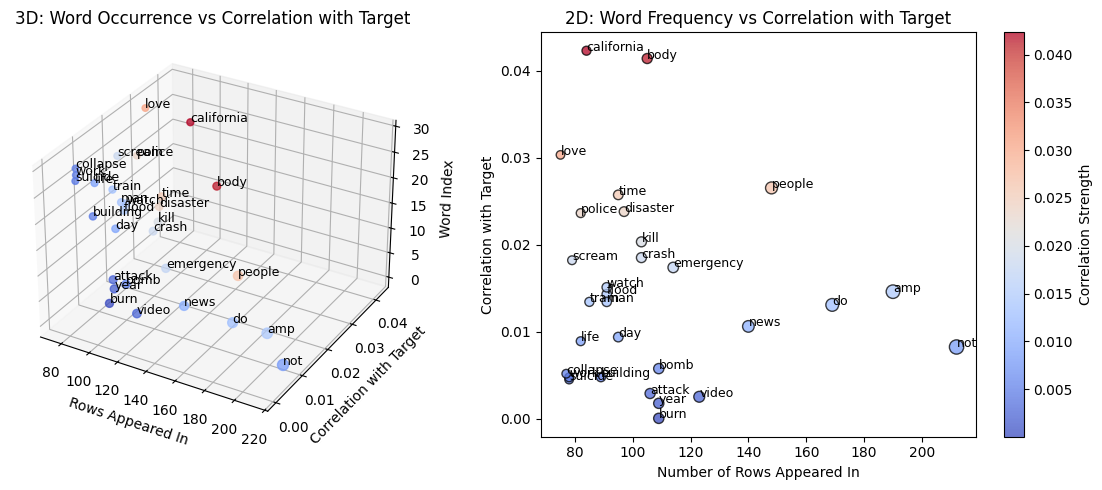

In [195]:
# Create a figure with two subplots
fig = plt.figure(figsize=(12, 5))

# -------- 3D Scatter Plot (Left Side) -------- #
ax1 = fig.add_subplot(121, projection="3d")

sc1 = ax1.scatter(
    word_stats["rows_appeared"],  # X-axis
    word_stats["correlation"],  # Y-axis
    range(len(word_stats)),  # Z-axis (just for spacing)
    s=word_stats["rows_appeared"] * 0.3,  # Bubble size
    c=word_stats["correlation"],  # Color based on correlation
    cmap="coolwarm",
    alpha=0.75
)

# Add word labels at select points
for i, word in enumerate(word_stats["word"]):
    ax1.text(word_stats["rows_appeared"].iloc[i], 
             word_stats["correlation"].iloc[i], 
             i, word, fontsize=9)

# Labels
ax1.set_xlabel("Rows Appeared In")
ax1.set_ylabel("Correlation with Target")
ax1.set_zlabel("Word Index")
ax1.set_title("3D: Word Occurrence vs Correlation with Target")

# -------- 2D Scatter Plot (Right Side) -------- #
ax2 = fig.add_subplot(122)

sc2 = ax2.scatter(
    word_stats["rows_appeared"], 
    word_stats["correlation"], 
    s=word_stats["rows_appeared"] * 0.5,  # Bubble size
    c=word_stats["correlation"],  # Color based on correlation
    cmap="coolwarm",
    alpha=0.75,
    edgecolors="k"
)

# Add labels to selected points
for i, word in enumerate(word_stats["word"]):
    ax2.annotate(word, 
                 (word_stats["rows_appeared"].iloc[i], word_stats["correlation"].iloc[i]), 
                 fontsize=9)

# Labels
ax2.set_xlabel("Number of Rows Appeared In")
ax2.set_ylabel("Correlation with Target")
ax2.set_title("2D: Word Frequency vs Correlation with Target")

# Add colorbar for better interpretation
cbar = fig.colorbar(sc2, ax=ax2)
cbar.set_label("Correlation Strength")

# Show both plots
plt.tight_layout()
plt.show()


### Fitting to test dataset

In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Get the training data for each df
X_train_words = vectorizer.fit_transform(train_df['text'])
X_dev_words = vectorizer.transform(test_df['text'])

# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")


F1 Score (Training Set): 0.7639
F1 Score (Development Set): 0.7048
